In [1]:
import os, sys, math
import numpy as np
#import pandas as pd
import sklearn as skl
import statistics
from sklearn.neighbors import NearestNeighbors, DistanceMetric
#from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
import scipy.special as sp
%matplotlib inline

In [2]:
# Define a routine to generate samples in parameter space:

def Sampler(nsamples=1000,ndim=2,mean=(1,10),stdev=(0.2,0.5)):

    # Number of samples:                 nsamples
    # Dimensionality of parameter space: ndim
    # Means:                             mean
    # Standard deviations:               stdev
 
    #Initialize vectors:
    
    theta = np.zeros((nsamples,ndim))
    f     = np.zeros(nsamples)
    
# Generate samples from an ndim-dimension multivariate gaussian:
# Second index represents the parameter.

    for i in range(0,nsamples):
        for dim in range(0,ndim):
            theta[i,dim] = np.random.normal(mean[dim],stdev[dim])

# Compute ln(likelihood):            
        f[i] = -0.5*np.dot((theta[i,:]-mean)/stdev,(theta[i,:]-mean)/stdev)-ndim*0.5*np.log(2.0*math.pi)-np.sum(np.log(stdev))

    return theta, f

(100000, 10)
('mean_sample, std_sample', array([  0.99219389,   2.00066907,   3.0014182 ,   3.99805176,
         5.00024176,   6.00106758,   6.99841654,   7.99698226,
         8.99932776,  10.00083073]), array([ 0.00316311,  0.00316806,  0.00315782,  0.00314263,  0.00316778,
        0.00316551,  0.00315446,  0.00316135,  0.00315965,  0.00315734]))


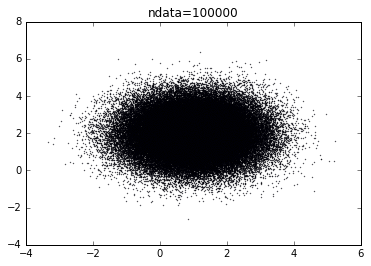

In [3]:
#  Generate data

# Number of dimensions: up to 15 this seems to work OK. 
ndim  = 10

# Number of data points (not actually very important)
ndata = 100000

# Some fairly arbitrary mean values for the data.  
# Standard deviation is unity in all parameter directions.

mean  = np.zeros(ndim)
stdev = np.zeros(ndim)

for i in range(0,ndim):
    mean[i]  = np.float(i+1)
    stdev[i] = 1.0

std = 1.0

# Generate random data all at once:
d2d=np.random.normal(mean,std,size=(ndata,ndim))

print(d2d.shape)

# Plot it:
plt.scatter(d2d[:,0],d2d[:,1],s=0.1)
plt.title('ndata='+str(ndata))

# [Not needed] Compute the sample mean and standard deviations, for each dimension
# The s.d. should be ~1/sqrt(ndata))

mean_sample = np.mean(d2d,axis=0)
var_sample  = np.var(d2d,axis=0)/np.float(ndata)
std_sample  = np.sqrt(var_sample)

print('mean_sample, std_sample',mean_sample, std_sample)


In [4]:
np.var(d2d,axis=0)

array([ 1.00052465,  1.00366234,  0.99718149,  0.98760953,  1.00348171,
        1.00204279,  0.99506322,  0.99941607,  0.99833991,  0.9968782 ])

(0, 1000, 1, 1.2116624549387447, 8.4749600221800719e-23, 0.0012104520029358088, 1.2104520029358088)
(0, 1000, 2, 2.5366171183453758, 2.3808885845753781e-22, 0.0012676747218117821, 1.2676747218117821)
(0, 1000, 3, 3.979344537396317, 3.6999152345961558e-22, 0.0013260061770730813, 1.3260061770730813)
(0, 1000, 4, 5.4477929554256681, 5.3226896854017857e-22, 0.0013616078368971927, 1.3616078368971927)
(1, 1199, 1, 1.2177374569357591, 6.4871921096279919e-23, 0.0010147812141131326, 1.2167226757216461)
(1, 1199, 2, 2.4509368696790998, 1.6549046867061141e-22, 0.0010216493829425177, 1.2249576101480786)
(1, 1199, 3, 3.8042763258959686, 2.7227605867978607e-22, 0.0010573308298765893, 1.2677396650220305)
(1, 1199, 4, 5.3083504221107223, 3.9795482837467854e-22, 0.001106597961665775, 1.3268109560372643)
(2, 1438, 1, 1.2163703959906456, 6.2806320183965772e-23, 0.0008452886699031588, 1.2155251073207423)
(2, 1438, 2, 2.4401553444349409, 1.6777184702528706e-22, 0.00084815966090891236, 1.219653592387016)
(2

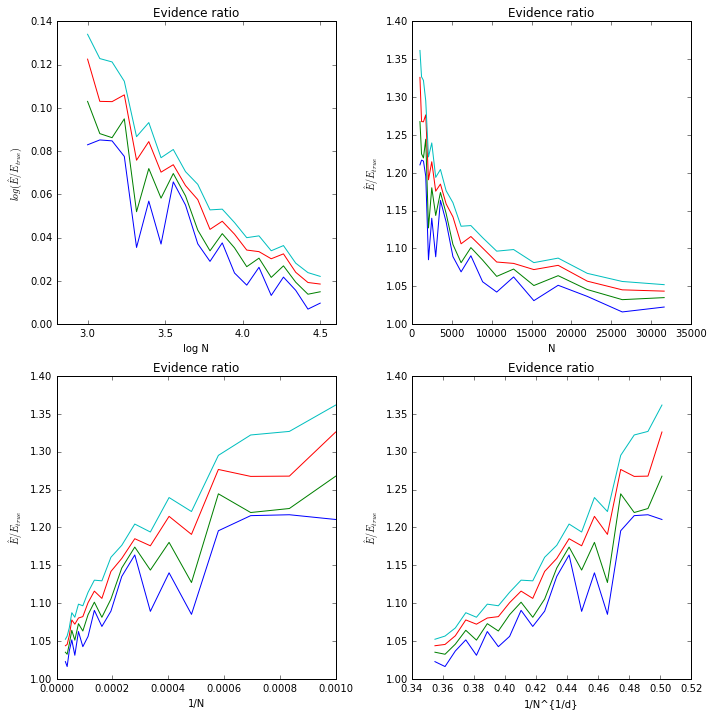

In [6]:
# Plot the ratio of estimated evidence to true evidence.
# Ntrials:        number of MCMC samples. These are equally-spaced logarithmically between limit given by:
# powmin, powmax: 10^powmin, 10^powmax are the minimum and maximum numbers of samples.  
#                 Typical MCMC has ~10^5 samples. powmax=5 is reasonably fast. powmax=6 takes hours.
# kmax:           The results are plotted using kth-nearest-neighbours, with k between 1 and kmax-1. 

Ntrials = 20
powmin  = 3
powmax  = 4.5
kmax    = 5

# MLE=maximum likelihood estimate of evidence:
# powers and nchain record the number of samples (just for plotting).

MLE     = np.zeros((Ntrials,kmax+1))
powers  = np.zeros(Ntrials)
nchain  = np.zeros(Ntrials)

# Parameter standard deviations:
Parstdev = np.zeros(ndim)

# Variance of likelihood distribution in parameter space = variance in data space = 1/ndata:
for i in range (0,ndim):
    Parstdev[i] = 1.0/np.sqrt(ndata)

# Loop over different numbers of MCMC samples (=S):

for ipow in range (0,Ntrials):
    powers[ipow] = powmin+float(ipow)*(powmax-powmin)/float(Ntrials-1)
    nchain[ipow] = int(pow(10.,powers[ipow]))
    S            = int(nchain[ipow])
    
    DkNN    = np.zeros((S,kmax+1))
    indices = np.zeros((S,kmax+1))
    volume  = np.zeros((S,kmax+1))
    
# Generate samples in parameter space by Gibbs sampling (trivial since everything is separable):

    samples,fs=Sampler(nsamples=S,ndim=ndim,mean=mean_sample,stdev=Parstdev)

# Use sklearn nearest neightbour routine, which chooses the 'best' algorithm.
# This is where the hard work is done:

    nbrs          = NearestNeighbors(n_neighbors=kmax+1, algorithm='auto').fit(samples)
    DkNN, indices = nbrs.kneighbors(samples)
    
# Create the posterior for 'a' from the distances (volumes) to nearest neighbour:

    for k in range(1,kmax):
        for j in range(0,S):
        
# Use analytic formula for the volume of ndim-sphere:
            volume[j,k] = math.pow(math.pi,ndim/2)*math.pow(DkNN[j,k],ndim)/sp.gamma(1+ndim/2)

# dotp is the summation term in the notes:
        dotp = np.dot(volume[:,k],np.exp(fs))
        
# The MAP value of 'a' is obtained analytically from the expression for the posterior:
        amax = dotp/(S*k+1.0)
    
# Maximum likelihood estimator for the evidence (this is normalised to the analytic value):
        MLE[ipow,k] = S*amax
    
# Output is: for each sample size (S), compute the evidence for kmax-1 different values of k.
# Final columm gives the evidence in units of the analytic value.
# The values for different k are clearly not independent. If ndim is large, k=1 does best.
        #if ipow=0: print('mean,min,max fs: ',fs.mean(),fs.min(),fs.max())
        print(ipow,S,k,dotp,statistics.median(volume[:,k]),amax,MLE[ipow,k])

# Plot the same information vs different functions of S (labelled as N, for comparison with notes)
# This is to see if any could be used to extrapolate to S=infinity.

fig,ax=plt.subplots(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(powers,np.log10(MLE[:,1:kmax]))
plt.xlabel('log N')
plt.ylabel('$log(\hat E / E_{true})$')
plt.title('Evidence ratio')

plt.subplot(2,2,2)
plt.plot(nchain,MLE[:,1:kmax])
plt.xlabel('N')
plt.ylabel('$\hat E / E_{true}$')
plt.title('Evidence ratio')

plt.subplot(2,2,3)
plt.plot(1/nchain,MLE[:,1:kmax])
plt.xlabel('1/N')
plt.ylabel('$\hat E / E_{true}$')
plt.title('Evidence ratio')

plt.subplot(2,2,4)
plt.plot(pow(nchain,-1.0/ndim),MLE[:,1:kmax])
plt.xlabel('1/N^{1/d}')
plt.ylabel('$\hat E / E_{true}$')
plt.title('Evidence ratio')

plt.tight_layout()